In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import sklearn

from sklearn import linear_model
from scipy import stats

from sklearn.linear_model import LinearRegression
from geopy.distance import distance

In [3]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
#                                                     for i in range(sse.shape[0])
#                     ])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [4]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [5]:
earnings = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_earnings_by_borough.csv'))

In [6]:
earnings.drop('confidence', axis=1, inplace=True)
earnings.dropna(inplace=True)

In [7]:
earnings.identity.value_counts()

Female       1665
Full-time    1663
Male         1651
Part-time     824
Part-Time     804
Name: identity, dtype: int64

In [8]:
earnings.head()

,year,area_code,area,identity,pay_type,pay
7,2009,00AA,City of London,Female,Hourly,17.56
10,2012,00AA,City of London,Female,Hourly,23.91
12,2014,00AA,City of London,Female,Hourly,16.74
13,2015,00AA,City of London,Female,Hourly,16.17
15,2017,00AA,City of London,Female,Hourly,22.15


In [270]:
earnings[earnings.year == 2015].area.value_counts()

South West                  8
Hounslow                    8
Richmond upon Thames        8
North West                  8
Tower Hamlets               8
Redbridge                   8
Croydon                     8
Enfield                     8
Greenwich                   8
Hillingdon                  8
Barnet                      8
Waltham Forest              8
Scotland                    8
Yorkshire and The Humber    8
Lambeth                     8
England and Wales           8
Barking and Dagenham        8
Havering                    8
Ealing                      8
Westminster                 8
North East                  8
Bromley                     8
Harrow                      8
East                        8
East Midlands               8
South East                  8
Newham                      8
Hackney                     8
Merton                      8
Southwark                   8
Wales                       8
West Midlands               8
London                      8
Brent     

In [9]:
# Assuming 40 hour work-week

def weekly_to_hourly(series):
    if series.pay_type == 'Weekly':
        series.pay_type = 'Hourly'
        series.pay /= 40
    
    return series
        
earnings = earnings.apply(weekly_to_hourly, axis=1)

In [153]:
earnings_per_area = earnings.pivot_table(index='area', columns='year', values='pay', aggfunc=np.median)

In [154]:
earnings_per_area.head()

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
area,,,,,,,,,,,,,,,,,,
Barking and Dagenham,9.69500,9.25375,9.54000,9.97500,10.62000,10.98000,11.55000,12.14625,11.52875,11.67500,11.9700,11.93500,11.58500,11.59500,11.87000,11.96500,12.49000,12.92375
Barnet,10.98875,11.96875,12.29750,11.98125,12.71875,12.69625,13.69625,14.22250,14.05625,14.30000,14.2650,14.54875,13.93250,13.88125,14.17875,15.41625,15.07500,15.38750
Bexley,10.40750,11.00000,10.92750,11.76375,11.53750,11.97750,12.54750,12.73500,12.94250,13.25250,13.6325,13.77000,13.70750,13.76750,14.36875,14.59250,14.80750,15.40000
Brent,9.65000,9.25000,10.37625,10.72750,10.77000,10.84125,11.19750,11.70000,11.20500,10.79125,11.9000,11.80125,11.74000,11.91625,12.24500,12.34500,12.77875,13.90125
Bromley,11.57625,12.06750,12.19875,12.62875,13.08500,14.16250,14.46750,14.93125,14.77500,14.97875,15.6350,15.96000,16.08375,16.15750,16.50125,16.88250,17.81875,17.91625


In [155]:
earnings_per_area.interpolate(inplace=True)

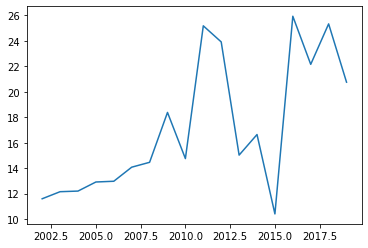

In [156]:
plt.plot(earnings_per_area.loc['City of London'])

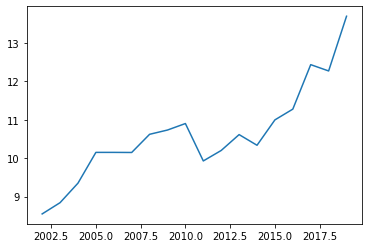

In [157]:
plt.plot(earnings_per_area.loc['Newham'])

Find difference in slopes before and after olympics
===================================================

In [158]:
before_olympics = earnings_per_area.loc[:, :2012]
after_olympics = earnings_per_area.loc[:, 2012:]

In [159]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [160]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [161]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / earnings_per_area.mean(axis=1)

In [162]:
slopes.head()

,before,after,diff
area,,,
Barking and Dagenham,0.293625,0.129360,-0.014544
Barnet,0.331295,0.181399,-0.010985
Bexley,0.310295,0.247813,-0.004824
Brent,0.202489,0.250476,0.004211
Bromley,0.415045,0.333363,-0.005490


Load london borough shape data
==============================

In [1]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

NameError: name 'gpd' is not defined

In [164]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [237]:
london_regions = map_df.NAME

In [165]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [166]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [167]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


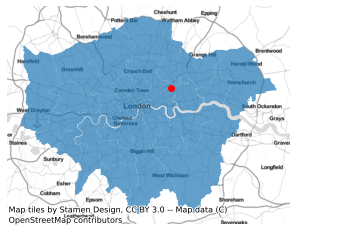

In [168]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [169]:
merged = map_df.set_index('NAME').join(slopes)

In [170]:
int_series = pd.Series(0.5, index=map_df.NAME)
int_series[['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']] = 1.

merged['interesting'] = int_series

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


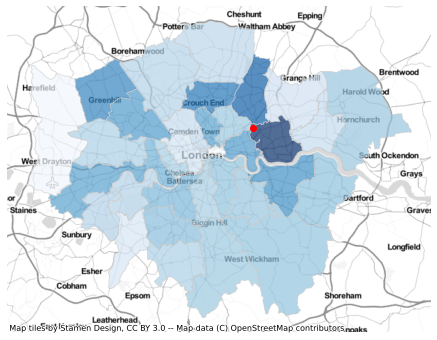

In [171]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [172]:
merged['before'] = merged['before'] / earnings_per_area.mean(axis=1)

In [173]:
merged['before']['City of London'] = 0

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [174]:
merged['before']

NAME
Kingston upon Thames      0.029392
Croydon                   0.025999
Bromley                   0.027894
Hounslow                  0.019001
Ealing                    0.017283
Havering                  0.023853
Hillingdon                0.028307
Harrow                    0.022751
Brent                     0.017768
Barnet                    0.024279
Lambeth                   0.030317
Southwark                 0.031716
Lewisham                  0.019509
Greenwich                 0.018642
Bexley                    0.023957
Enfield                   0.022140
Waltham Forest            0.015399
Redbridge                 0.024737
Sutton                    0.025882
Richmond upon Thames      0.017945
Merton                    0.018919
Wandsworth                0.026024
Hammersmith and Fulham    0.022251
Kensington and Chelsea    0.025166
Westminster               0.034328
Camden                    0.025135
Tower Hamlets             0.025355
Islington                 0.024920
Hackney        

In [175]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [176]:
mdists = map_df.set_index('NAME').join(dists)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


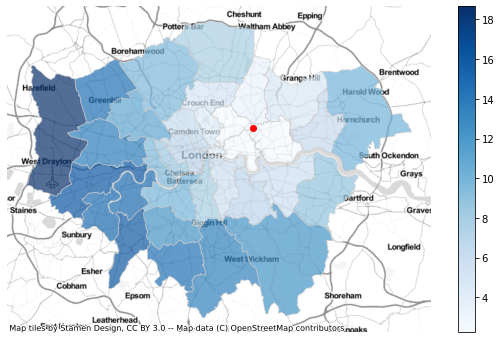

In [177]:
fig, ax = plt.subplots(1, figsize=(10, 6))
mdists.plot(column='Distance', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


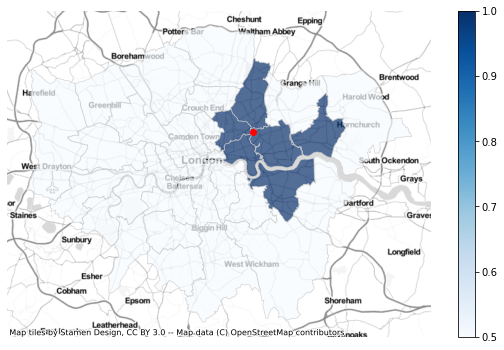

In [178]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='interesting', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

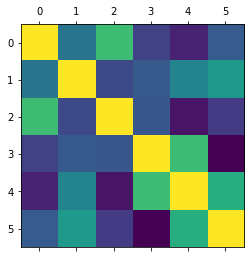

In [179]:
plt.matshow(mdists.join(slopes).corr())

In [180]:
mdists.join(slopes).corr()

,HECTARES,NONLD_AREA,Distance,before,after,diff
HECTARES,1.000000,0.032552,0.509195,-0.272427,-0.420749,-0.126274
NONLD_AREA,0.032552,1.000000,-0.228227,-0.132973,0.136909,0.274174
Distance,0.509195,-0.228227,1.000000,-0.156613,-0.493719,-0.299823
before,-0.272427,-0.132973,-0.156613,1.000000,0.505625,-0.578078
after,-0.420749,0.136909,-0.493719,0.505625,1.000000,0.402158
diff,-0.126274,0.274174,-0.299823,-0.578078,0.402158,1.000000


In [181]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [182]:
profiles.set_index('Area_name').loc['Newham']

Code                                                            E09000025
Inner/_Outer_London                                          Inner London
GLA_Population_Estimate_2017                                       342900
GLA_Household_Estimate_2017                                        119172
Inland_Area_(Hectares)                                              3,620
                                                                 ...     
Political_control_in_council                                          Lab
Proportion_of_seats_won_by_Conservatives_in_2014_election               0
Proportion_of_seats_won_by_Labour_in_2014_election                    100
Proportion_of_seats_won_by_Lib_Dems_in_2014_election                    0
Turnout_at_2014_local_elections                                      40.5
Name: Newham, Length: 83, dtype: object

In [183]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                          0.046950
Average_Age,_2017                                    -0.439301
Proportion_of_population_aged_0-15,_2015              0.222089
Proportion_of_population_of_working-age,_2015         0.127589
Proportion_of_population_aged_65_and_over,_2015      -0.362703
New_migrant_(NINo)_rates,_(2015/16)                   0.198830
Employment_rate_(%)_(2015)                            0.074673
%_of_employment_that_is_in_public_sector_(2014)       0.402033
Jobs_Density,_2015                                   -0.363785
Number_of_active_businesses,_2015                     0.040673
Two-year_business_survival_rates_(started_in_2013)    0.014076
Number_of_cars,_(2011_Census)                         0.043324
Number_of_cars_per_household,_(2011_Census)          -0.142895
%_children_living_in_out-of-work_households_(2015)    0.319927
Life_satisfaction_score_2011-14_(out_of_10)           0.033907
Worthwhileness_score_2011-14_(out_of_10)             -0

In [184]:
profiles.set_index('Area_name').join(dists).corr().loc['Distance']

GLA_Population_Estimate_2017                          0.035107
Average_Age,_2017                                     0.416243
Proportion_of_population_aged_0-15,_2015              0.142736
Proportion_of_population_of_working-age,_2015        -0.535341
Proportion_of_population_aged_65_and_over,_2015       0.549599
New_migrant_(NINo)_rates,_(2015/16)                  -0.468055
Employment_rate_(%)_(2015)                            0.530636
%_of_employment_that_is_in_public_sector_(2014)      -0.316548
Jobs_Density,_2015                                   -0.201112
Number_of_active_businesses,_2015                    -0.197319
Two-year_business_survival_rates_(started_in_2013)    0.566712
Number_of_cars,_(2011_Census)                         0.570414
Number_of_cars_per_household,_(2011_Census)           0.715940
%_children_living_in_out-of-work_households_(2015)   -0.610379
Life_satisfaction_score_2011-14_(out_of_10)           0.480959
Worthwhileness_score_2011-14_(out_of_10)              0

In [185]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [186]:
fa = FactorAnalyzer()

In [187]:
all_things = profiles.set_index('Area_name').join(dists).join(slopes)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = all_things.select_dtypes(include=numerics)
newdf.dropna(inplace=True)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [188]:
x_test = newdf.drop(['before', 'after', 'diff', 'Proportion_of_population_aged_0-15,_2015', 'Proportion_of_population_of_working-age,_2015', 'Proportion_of_population_aged_65_and_over,_2015'], axis=1)

In [189]:
reg_diff = LinearRegression()

reg_diff.fit(x_test, newdf['diff'])

LinearRegression()

In [190]:
reg_diff.coef_

array([ 1.21773738e-07,  3.38815984e-03,  5.64297445e-04,  1.60924100e-03,
        1.71873597e-05, -8.37873317e-04, -3.22841523e-07,  7.07644799e-04,
       -3.49326567e-07,  5.47966236e-02,  1.29442214e-03, -1.51627395e-02,
       -6.92941920e-04,  1.18646707e-02,  5.91841379e-03, -2.18332325e-03,
       -1.65394195e-03])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

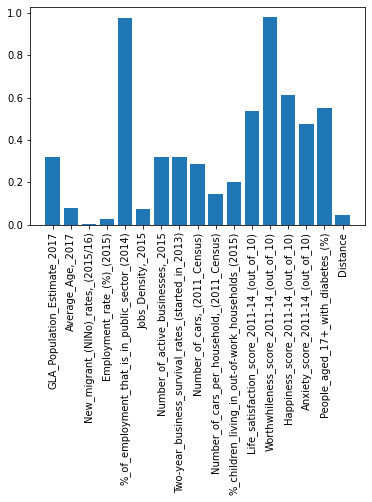

In [191]:
plt.bar(x_test.columns, reg_diff.p[0])
plt.xticks(rotation=90)

In [192]:
reg_second = LinearRegression()
reg_second.fit(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']], newdf['diff'])

LinearRegression()

In [193]:
sklearn.metrics.r2_score(newdf['diff'], reg_second.predict(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']]))

0.41845064958902567

In [194]:
reg_diff.p[reg_diff.p < 0.05]

array([0.00132768, 0.02705553, 0.04630977])

In [195]:
y_preds = reg_diff.predict(x_test)

In [196]:
sklearn.metrics.r2_score(newdf['diff'], y_preds)

0.7604216398786825

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

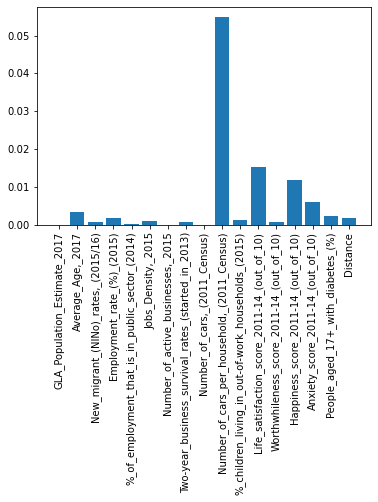

In [197]:
plt.bar(x_test.columns, abs(reg_diff.coef_))
plt.xticks(rotation=90)

In [198]:
fa.fit(newdf)

FactorAnalyzer(rotation_kwargs={})

[Text(0, 0, 'GLA_Population_Estimate_2017'),
 Text(0, 0, 'Average_Age,_2017'),
 Text(0, 0, 'Proportion_of_population_aged_0-15,_2015'),
 Text(0, 0, 'Proportion_of_population_of_working-age,_2015'),
 Text(0, 0, 'Proportion_of_population_aged_65_and_over,_2015'),
 Text(0, 0, 'New_migrant_(NINo)_rates,_(2015/16)'),
 Text(0, 0, 'Employment_rate_(%)_(2015)'),
 Text(0, 0, '%_of_employment_that_is_in_public_sector_(2014)'),
 Text(0, 0, 'Jobs_Density,_2015'),
 Text(0, 0, 'Number_of_active_businesses,_2015'),
 Text(0, 0, 'Two-year_business_survival_rates_(started_in_2013)'),
 Text(0, 0, 'Number_of_cars,_(2011_Census)'),
 Text(0, 0, 'Number_of_cars_per_household,_(2011_Census)'),
 Text(0, 0, '%_children_living_in_out-of-work_households_(2015)'),
 Text(0, 0, 'Life_satisfaction_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Worthwhileness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Happiness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Anxiety_score_2011-14_(out_of_10)'),
 Text(0, 0, 'People_aged_17+_with_d

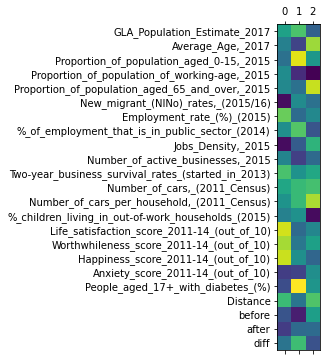

In [199]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.matshow(fa.loadings_)
ax.set_yticks(range(len(newdf.columns)))
ax.set_yticklabels(newdf.columns)

In [200]:
fa.loadings_

array([[ 0.24547422,  0.52535424, -0.25236774],
       [-0.01310599, -0.46382737,  0.78783336],
       [-0.13418195,  0.98691797,  0.1640128 ],
       [ 0.08257021, -0.61033132, -0.85574333],
       [ 0.04468742, -0.14024326,  0.90876424],
       [-0.79426137,  0.07769281, -0.13763798],
       [ 0.63151817, -0.18427602,  0.0424668 ],
       [ 0.09411284,  0.55546865, -0.3450817 ],
       [-0.79276661, -0.29817607,  0.40165347],
       [ 0.01073183, -0.49155376, -0.18620445],
       [ 0.51627312,  0.12392048,  0.29784938],
       [ 0.28345025,  0.44015065,  0.50073408],
       [ 0.13217644,  0.44033967,  0.82895167],
       [-0.00880141,  0.12071479, -0.80069182],
       [ 0.94116374, -0.19183096,  0.03140976],
       [ 0.81392463, -0.09413135,  0.23842955],
       [ 0.91774201,  0.1015864 , -0.21582117],
       [-0.50787676, -0.46525652,  0.10009137],
       [-0.39771086,  1.07199205,  0.15313527],
       [ 0.45897779, -0.10868231,  0.54104039],
       [-0.35311946, -0.69256994,  0.224

In [201]:
calculate_kmo(newdf)

(array([0.50216398, 0.48389288, 0.44327429, 0.46253001, 0.39373054,
        0.57207465, 0.39462176, 0.41071849, 0.74371811, 0.36568836,
        0.46449176, 0.61088858, 0.61405574, 0.55693253, 0.58507662,
        0.59374054, 0.80475796, 0.78678771, 0.45007243, 0.64870118,
        0.51238868, 0.43937609, 0.26785236]),
 0.5237577336743425)

In [202]:
calculate_bartlett_sphericity(newdf)

(1270.5143265718195, 1.8027282688251713e-135)

In [203]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(newdf, 25)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([9.19119153e+00, 5.42543613e+00, 2.06525622e+00, 1.40479121e+00,
       1.12083641e+00, 9.52603924e-01, 8.22746921e-01, 4.76453481e-01,
       4.00757358e-01, 3.11282481e-01, 2.11762244e-01, 1.66720897e-01,
       1.43566913e-01, 1.30272976e-01, 7.78832906e-02, 3.32999279e-02,
       2.69507138e-02, 1.88961664e-02, 1.05069168e-02, 5.07444119e-03,
       2.80094254e-03, 9.01325750e-04, 7.58028157e-06])

Wealth Gap
==========

In [207]:
olympic_boroughs = ['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']

In [208]:
def split_olympics(series):
    
    return pd.Series({
        'olympic_avg': series[olympic_boroughs].median(),
        'nonolympic_avg': series[~series.index.isin(olympic_boroughs)].median(),
        'total_avg': series.median()
    })

In [242]:
earnings.head()

,year,area_code,area,identity,pay_type,pay
7,2009,00AA,City of London,Female,Hourly,17.56
10,2012,00AA,City of London,Female,Hourly,23.91
12,2014,00AA,City of London,Female,Hourly,16.74
13,2015,00AA,City of London,Female,Hourly,16.17
15,2017,00AA,City of London,Female,Hourly,22.15


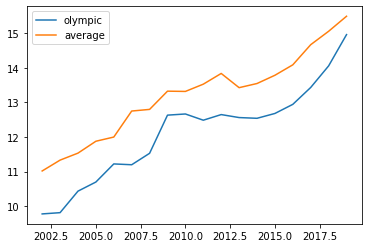

In [248]:
plt.plot(earnings[earnings.area.isin(olympic_boroughs)].pivot_table(index='year', values='pay', aggfunc=np.median), label='olympic')
plt.plot(earnings[earnings.area.isin(london_regions)].pivot_table(index='year', values='pay', aggfunc=np.median), label='average')
plt.legend()

In [250]:
olympic_avg = earnings[earnings.area.isin(olympic_boroughs)].pivot_table(index='year', values='pay', aggfunc=np.median)
overall_avg = earnings[earnings.area.isin(london_regions)].pivot_table(index='year', values='pay', aggfunc=np.median)

(0.0, 2.5)

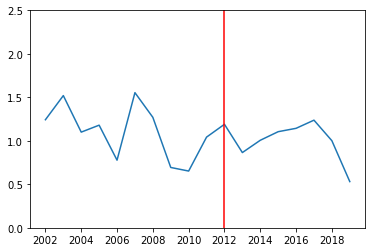

In [268]:
f, ax = plt.subplots(1)
ax.plot(overall_avg - olympic_avg)
plt.xticks(range(2002, 2019, 2))
ax.axvline(2012, color='red')
ax.set_ylim(bottom=0, ymax=2.5)

In [211]:
income_info = earnings_per_area.apply(split_olympics)

In [212]:
income_info

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
olympic_avg,10.40625,10.7725,10.928125,11.368125,11.475625,11.81375,12.36750,12.850625,12.993125,12.758125,12.603125,12.85500,12.854375,13.12000,13.38875,13.97125,14.433125,15.399375
nonolympic_avg,10.45000,11.0050,11.275000,11.600000,11.878750,12.31250,12.67625,13.053750,13.403750,13.217500,13.536250,13.72500,13.638750,13.59375,14.14750,14.54250,14.757500,15.047500
total_avg,10.45000,11.0050,11.106250,11.553750,11.662500,12.31000,12.67125,13.053750,13.403750,13.217500,13.502500,13.72125,13.583750,13.59375,13.93625,14.54250,14.757500,15.067500


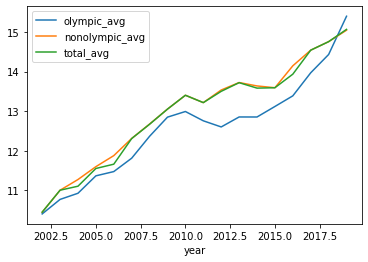

In [213]:
income_info.transpose().plot.line()

In [134]:
income_info[2009]

olympic_avg       90.58125
nonolympic_avg    92.24750
total_avg         92.24750
Name: 2009, dtype: float64

In [135]:
income_info[2015]

olympic_avg       94.50125
nonolympic_avg    95.81250
total_avg         95.81250
Name: 2015, dtype: float64

In [137]:
income_info[2009]['total_avg'] - income_info[2009]['olympic_avg']

1.6662500000000051

In [138]:
income_info[2015]['total_avg'] - income_info[2015]['olympic_avg']

1.311249999999987